#**Topic:** Missouri County Income Forecasting: Spatial Econometrics vs. Standard Regression (OLS)


## **📝Summary**

This workbook builds and evaluates spatial econometric models to forecast county-level median household income in Missouri using ACS 5-year data (2013, 2018, 2023). It includes:

* **Data ingestion** via the U.S. Census API and panel assembly
* **Model specifications**: OLS, Spatial‐Lag, and parsimonious alternatives
* **Back‐transformation** of log-predictions using Duan’s smearing estimator
* **Performance metrics**: $R^2$, AIC/BIC, RMSE (dollars), Breusch–Pagan, and Moran’s I
* **Diagnostics** for collinearity (VIF), residual normality, heteroskedasticity, and spatial autocorrelation
* **Spatial visualizations** of predicted vs. actual incomes and residual maps

The goal is to identify a stable, interpretable model that captures both socioeconomic drivers and spatial spillovers for accurate out-of-sample forecasting.


##**🛠️Data Setup**

In [ ]:
%pip install pandas
%pip install Census
%pip install us
%pip install libpysal
%pip install spreg
%pip install folium
%pip install geopandas
%pip install esda
%pip install folium
%pip install matplotlib
%pip install mapclassify

In [ ]:
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import KNN
import geopandas as gpd
import requests
import tempfile
import os
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
from spreg import ML_Lag
from libpysal.weights import Queen
import plotly.express as px
from esda.moran import Moran
from sklearn.metrics import mean_squared_error
from statsmodels.stats.diagnostic import het_breuschpagan
import statsmodels.api as sm
from scipy import sparse
from scipy.sparse.linalg import spsolve
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

##🗄️**Data Sources & Variables**

**Data Sources:**

The data is extracted using the **US Census Bureau API**, which allow data extraction directly from US Census Bureau (**no manual downloads!**). The API will pull:

*   County-level ACS 5-Year estimates
*   TIGER/Line cartographic boundaries for Missouri

This gives us both the socioeconomic attributes and the geometries needed for mapping and spatial modeling.

**Variables:**

* **med_income ($)**:
Median household income (dollars)

* **pct_poverty (%)**:
Captures the depth of economic hardship; higher poverty rates reliably depress median incomes.

* **pct_male (%)**:
Reflects gender composition with just one variable (pct_male + pct_female = 100%), avoiding collinearity (because pct_male + pct_female = 100%). Male share often proxies for labor-force participation differences.

* **pct_18_64 (%)**:
Measures the working-age population’s share—regions with more prime-age adults tend to generate higher aggregate earnings.

* **pct_bachelor_or_higher (%)**:
Summarizes local human capital by pooling all college-educated adults (bachelor’s degree and above) into one interpretable metric, reducing complexity and multicollinearity among finer education bins.

We'll start first by extracting ACS 5-year socioeconomic data. To do so, an API Key is needed. Here's the API documentation: https://www.census.gov/data/developers/guidance/api-user-guide.html

In [ ]:
# County-level ACS 5-Year estimates:

API_KEY = "693ed38cee1910f690d32e8d463f857ee0603775"

# ----------------------------------------
# Core fetch function for ACS 5-year data
# ----------------------------------------


def fetch_core(year, vars_list):
    url = (
        f"https://api.census.gov/data/{year}/acs/acs5?"
        f"get={','.join(vars_list)}"
        f"&for=county:*&in=state:29"       # <-- county instead of tract
        f"&key={API_KEY}"
    )
    resp = requests.get(url)
    resp.raise_for_status()

    data = resp.json()
    df = pd.DataFrame(data[1:], columns=data[0])

    # Only coerce the requested estimate columns
    non_geo = set(vars_list) - {"NAME"}
    for col in non_geo:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Add year and geoid at the county level
    df["year"]  = int(year)
    df["geoid"] = df.state + df.county       # <— no df.tract any more
    return df

# ----------------------------------------
# Individual variable fetchers
# ----------------------------------------

def fetch_tract_names(year):
    df = fetch_core(year, ['NAME'])
    return df[['geoid','year','NAME']]

def fetch_income(year):
    df = fetch_core(year, ['B19013_001E'])
    return df.rename(columns={'B19013_001E':'med_income'})[['geoid','year','med_income']]

def fetch_poverty_rate(year):
    df = fetch_core(year, ['B17001_002E','B01003_001E'])
    df = df.rename(columns={'B17001_002E':'poverty_count','B01003_001E':'total_pop'})
    df['pct_poverty'] = df['poverty_count'] / df['total_pop']
    return df[['geoid','year','pct_poverty']]

def fetch_sex_sub(year):
    male_vars   = [f"B01001_{i:03d}E" for i in range(2, 26)]
    female_vars = [f"B01001_{i:03d}E" for i in range(26, 50)]

    # pull the detailed bins + the published total (just in case)
    df = fetch_core(year, male_vars + female_vars + ['B01001_001E'])

    # sum your own male & female totals
    df['male_tot']   = df[male_vars].sum(axis=1)
    df['female_tot'] = df[female_vars].sum(axis=1)

    # recompute population from those two sums
    df['pop_calc'] = df['male_tot'] + df['female_tot']

    # now true percentages (0–100)
    df['pct_male']   = df['male_tot']   / df['pop_calc']
    df['pct_female'] = df['female_tot'] / df['pop_calc']

    return df[['geoid', 'year', 'pct_male', 'pct_female']]


def fetch_edu_pct_bachelor(year):
    df = fetch_core(year, ['B15003_022E','B15003_023E','B15003_024E','B15003_025E','B15003_001E'])
    df = df.rename(columns={'B15003_001E':'edu_universe'})
    df['count_bach_or_higher'] = df[['B15003_022E','B15003_023E','B15003_024E','B15003_025E']].sum(axis=1)
    df['pct_bachelor_or_higher'] = df['count_bach_or_higher'] / df['edu_universe']
    return df[['geoid','year','pct_bachelor_or_higher']]

def fetch_age_vars(year):
    under18   = [f"B01001_{i:03d}E" for i in (3,4,5,6,27,28,29,30)]
    work18_64 = [f"B01001_{i:03d}E" for i in list(range(7,20))+list(range(31,44))]
    over65    = [f"B01001_{i:03d}E" for i in list(range(20,27))+list(range(44,50))]
    df = fetch_core(year, under18+work18_64+over65+['B01001_001E'])
    df = df.rename(columns={'B01001_001E':'pop'})
    df['pct_18_64']   = df[work18_64].sum(axis=1) / df['pop']
    return df[['geoid','year','pct_18_64']]

# ----------------------------------------
# Assemble full panel
# ----------------------------------------

def fetch_all(year):
    parts = [
        fetch_tract_names(year),
        fetch_income(year),
        fetch_poverty_rate(year),
        fetch_sex_sub(year),
        fetch_edu_pct_bachelor(year),
        fetch_age_vars(year),
    ]
    df = parts[0]
    for p in parts[1:]:
        df = df.merge(p, on=['geoid','year'], how='left')
    return df

panel_df = pd.concat([fetch_all(y) for y in ['2013','2018','2023']], ignore_index=True)


Quick Check:

Now, we need to load TIGER/Line cartographic boundaries for Missouri, which includes geospatial data that we will later use for spatial modeling and analysis. Helpful documentation: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

/usr/local/lib/python3.11/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www2.census.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


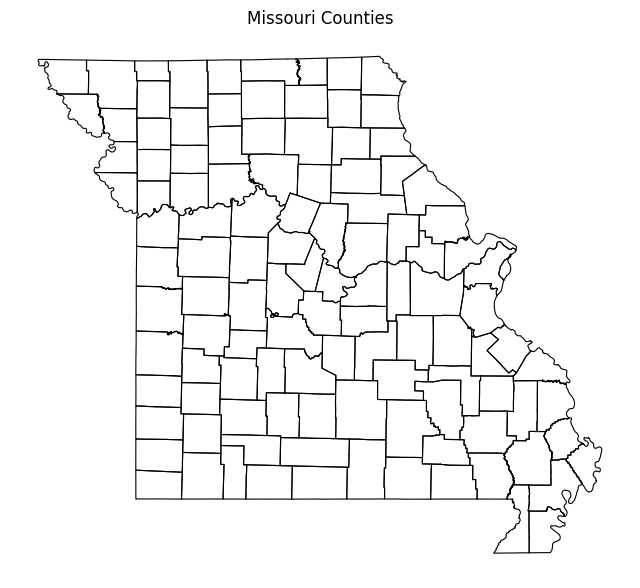

In [ ]:
# TIGER/Line cartographic boundaries for Missouri:
url = "https://www2.census.gov/geo/tiger/GENZ2022/shp/cb_2022_us_county_500k.zip"
resp = requests.get(url, stream=True, verify=False)
resp.raise_for_status()

# create a temp directory
tmpdir = tempfile.mkdtemp()
zip_path = os.path.join(tmpdir, "cb_county.zip")

# write out the zip file
with open(zip_path, "wb") as f:
    for chunk in resp.iter_content(1024 * 1024):
        f.write(chunk)

# 2. Read with GeoPandas
gdf = gpd.read_file(f"zip://{zip_path}")

# 3. Filter to Missouri (STATEFP == "29")
mo_counties = gdf[gdf.STATEFP == "29"].copy()

# 5. Plot (for example)
fig, ax = plt.subplots(figsize=(8, 8))
mo_counties.plot(
    ax=ax,
    facecolor='none',    # transparent fill
    edgecolor='black',   # boundary lines
    linewidth=0.8
)
ax.set_title("Missouri Counties")
ax.set_axis_off()
plt.show()

##**🧹Data Preparation**

First, we'll inspect the American Community Survey (ACS) 5-Year Estimates data:

In [ ]:
panel_df.head()

,geoid,year,NAME,med_income,pct_poverty,pct_male,pct_female,pct_bachelor_or_higher,pct_18_64
0,29195,2013,"Saline County, Missouri",39519,0.173941,0.497985,0.502015,0.172035,0.608386
1,29227,2013,"Worth County, Missouri",39348,0.128229,0.491310,0.508690,0.155526,0.554721
2,29079,2013,"Grundy County, Missouri",37964,0.152986,0.478992,0.521008,0.149191,0.551352
3,29141,2013,"Morgan County, Missouri",34797,0.229306,0.496469,0.503531,0.127460,0.561250
4,29179,2013,"Reynolds County, Missouri",34496,0.238102,0.509833,0.490167,0.067269,0.564480


Notice that the NAME column includes both County and Staes, we need to split the column:

In [ ]:
# Perform at most two splits on ',' or ';'
parts = panel_df['NAME'].str.split(r'[;,]', n=2, regex=True, expand=True)

# Trim whitespace from each piece
parts = parts.apply(lambda col: col.str.strip())

# Assign column names and join back
parts.columns = ['county','state']
panel_df = panel_df.join(parts)

# Drop NAME:
final_cleaned = panel_df.drop(columns=['NAME'])

In [ ]:
# Validate:
final_cleaned.head()

,geoid,year,med_income,pct_poverty,pct_male,pct_female,pct_bachelor_or_higher,pct_18_64,county,state
0,29195,2013,39519,0.173941,0.497985,0.502015,0.172035,0.608386,Saline County,Missouri
1,29227,2013,39348,0.128229,0.491310,0.508690,0.155526,0.554721,Worth County,Missouri
2,29079,2013,37964,0.152986,0.478992,0.521008,0.149191,0.551352,Grundy County,Missouri
3,29141,2013,34797,0.229306,0.496469,0.503531,0.127460,0.561250,Morgan County,Missouri
4,29179,2013,34496,0.238102,0.509833,0.490167,0.067269,0.564480,Reynolds County,Missouri


The data looks ready! Now we need to join the two datasets using a Geospatial Join:

In [ ]:
# Geospatial join (US Census Data + Counties Data):

gdf = gdf.rename(columns={'GEOID':'geoid'})
gdf['geoid'] = gdf['geoid'].astype(str)
final_cleaned['geoid'] = final_cleaned['geoid'].astype(str)

gdf_mo = gdf.merge(final_cleaned, on='geoid', how='inner').reset_index(drop=True)
gdf_mo

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,geoid,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,...,geometry,year,med_income,pct_poverty,pct_male,pct_female,pct_bachelor_or_higher,pct_18_64,county,state
0,29,031,00758470,0500000US29031,29031,Cape Girardeau,Cape Girardeau County,MO,Missouri,06,...,"POLYGON ((-89.8668 37.21898, -89.86326 37.2190...",2013,46516,0.150874,0.481447,0.518553,0.274199,0.636920,Cape Girardeau County,Missouri
1,29,031,00758470,0500000US29031,29031,Cape Girardeau,Cape Girardeau County,MO,Missouri,06,...,"POLYGON ((-89.8668 37.21898, -89.86326 37.2190...",2018,51730,0.163424,0.484296,0.515704,0.305417,0.626360,Cape Girardeau County,Missouri
2,29,031,00758470,0500000US29031,29031,Cape Girardeau,Cape Girardeau County,MO,Missouri,06,...,"POLYGON ((-89.8668 37.21898, -89.86326 37.2190...",2023,68912,0.134145,0.488525,0.511475,0.338738,0.612984,Cape Girardeau County,Missouri
3,29,201,00758553,0500000US29201,29201,Scott,Scott County,MO,Missouri,06,...,"POLYGON ((-89.78682 37.08782, -89.78563 37.089...",2013,40651,0.187653,0.483349,0.516651,0.145983,0.600469,Scott County,Missouri
4,29,201,00758553,0500000US29201,29201,Scott,Scott County,MO,Missouri,06,...,"POLYGON ((-89.78682 37.08782, -89.78563 37.089...",2018,42231,0.202536,0.483152,0.516848,0.145026,0.587673,Scott County,Missouri
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,29,175,00758542,0500000US29175,29175,Randolph,Randolph County,MO,Missouri,06,...,"POLYGON ((-92.70632 39.34168, -92.70637 39.345...",2018,46610,0.140589,0.525236,0.474764,0.152932,0.622089,Randolph County,Missouri
341,29,175,00758542,0500000US29175,29175,Randolph,Randolph County,MO,Missouri,06,...,"POLYGON ((-92.70632 39.34168, -92.70637 39.345...",2023,55310,0.145694,0.519410,0.480590,0.170957,0.608343,Randolph County,Missouri
342,29,039,00758474,0500000US29039,29039,Cedar,Cedar County,MO,Missouri,06,...,"POLYGON ((-94.07352 37.63972, -94.07298 37.657...",2013,30302,0.225994,0.499604,0.500396,0.146286,0.544199,Cedar County,Missouri
343,29,039,00758474,0500000US29039,29039,Cedar,Cedar County,MO,Missouri,06,...,"POLYGON ((-94.07352 37.63972, -94.07298 37.657...",2018,39412,0.182020,0.499426,0.500574,0.153448,0.527479,Cedar County,Missouri


To evaluate out-of-sample forecasting performance, we hold out the most recent year (2023) as our test set and train on all prior years (2013 & 2018):

* Training set: Counties × years ≠ 2023 (used to estimate model parameters)

* Test set: Counties × year == 2023 (used only to compute prediction errors)





In [ ]:
# 4) Split into train/test:

train_df = gdf_mo.loc[gdf_mo['year'] != 2023].reset_index(drop=True)
test_df  = gdf_mo.loc[gdf_mo['year'] == 2023].reset_index(drop=True)

# 5) Inspect and save
print(f"Train rows: {len(train_df)}")
print(f"Test rows:  {len(test_df)}")

Train rows: 230
Test rows:  115


##**🔍 Exploratory Data Analysis**

First, let's visualize the Median Income by County using a Choroepleth Map:

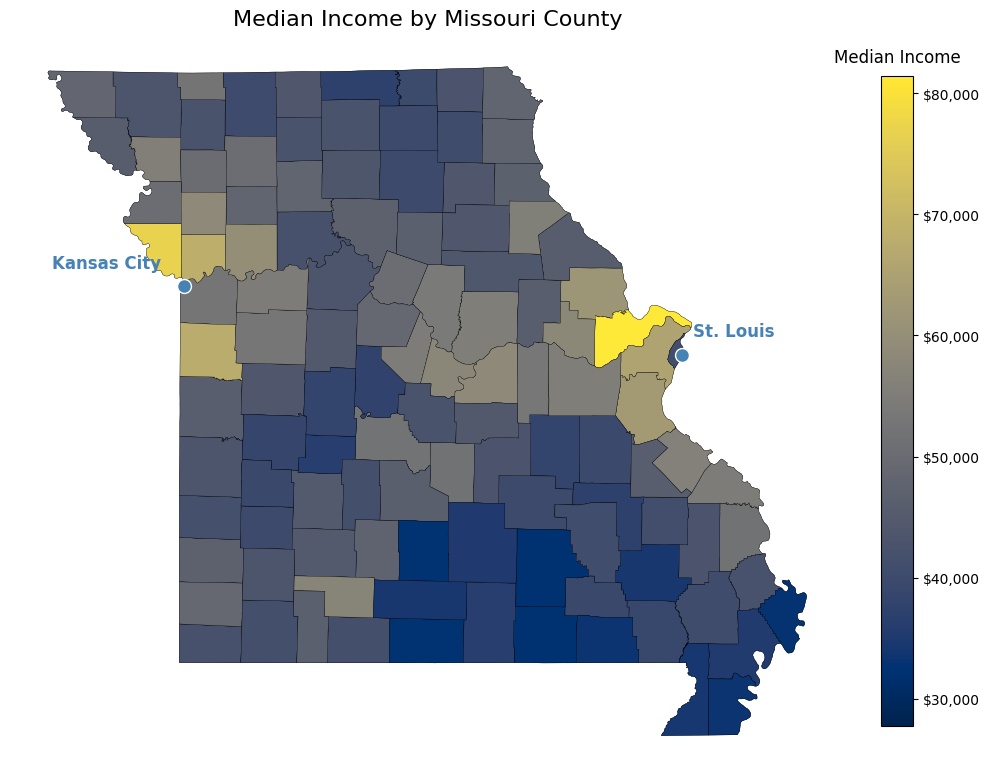

In [ ]:
# Map by Income:

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 1) draw the county choropleth
chor = train_df.plot(
    column='med_income',
    cmap='cividis',
    linewidth=0.2,
    edgecolor='black',
    legend=False,
    ax=ax
)

# 2) build a ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(
    cmap='cividis',
    norm=mpl.colors.Normalize(
        vmin=train_df['med_income'].min(),
        vmax=train_df['med_income'].max()
    )
)
sm._A = []

# 3) add the colorbar
cbar = fig.colorbar(sm, ax=ax, fraction=0.036, pad=0.04)
cbar.ax.set_title("Median Income", pad=10)

# 4) use FuncFormatter to format ticks as currency
cbar.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, _: f'${x:,.0f}')
)

# 4) city pins & labels
cities = {
    "Kansas City": (-94.5786, 39.0997),
    "St. Louis":   (-90.1994, 38.6270),
}
for name, (lon, lat) in cities.items():
    ax.scatter(lon, lat, color='steelblue', edgecolor='white', s=100, zorder=5)
    dx = -0.2 if name == "Kansas City" else 0.1
    dy = 0.1
    ha = 'right' if name == "Kansas City" else 'left'
    ax.text(lon + dx, lat + dy, name, color='steelblue',
            fontsize=12, weight='bold', ha=ha, va='bottom')

ax.set_title("Median Income by Missouri County", fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()


The map shows that the counties with high median income tend to cluster around the two big areas in the state of Missouri: Kansas City and St. Louis Metro, which obscures patterns in lower- and middle-income counties, signaling the existence of outliers in our data.

So we need to check for outliers and examine the distribution. Let's add a box plot next to the map:

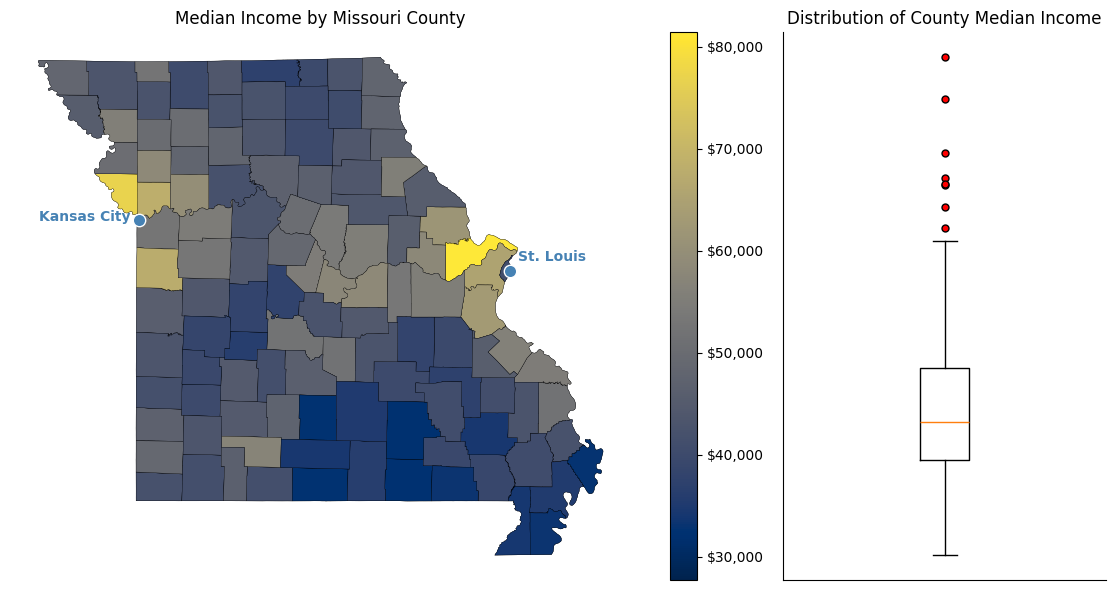

In [ ]:
# Outliers:

# compute vmin/vmax for the map
vmin, vmax = train_df['med_income'].min(), train_df['med_income'].max()

fig, (ax_map, ax_box) = plt.subplots(
    1, 2,
    figsize=(14, 6),
    gridspec_kw={"width_ratios": [3, 1]}
)

# --- 1/ Choropleth -----
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='cividis', norm=norm)
sm._A = []

train_df.plot(
    column='med_income',
    cmap='cividis',
    norm=norm,
    edgecolor='black',
    linewidth=0.2,
    legend=False,
    ax=ax_map
)

# City pins
cities = {
    "Kansas City": (-94.5786, 39.0997),
    "St. Louis":   (-90.1994, 38.6270),
}
for name, (lon, lat) in cities.items():
    ax_map.scatter(lon, lat, color='steelblue', edgecolor='white', s=80, zorder=5)

# labels
ax_map.text(cities["St. Louis"][0] + 0.1, cities["St. Louis"][1] + 0.1,
            "St. Louis", color='steelblue', fontsize=10, weight='bold')
ax_map.text(cities["Kansas City"][0] - 0.1, cities["Kansas City"][1] + 0.1,
            "Kansas City", ha='right', va='top',
            color='steelblue', fontsize=10, weight='bold')

# colorbar
cbar = fig.colorbar(sm, ax=ax_map, fraction=0.036, pad=0.04)
#cbar.ax.set_title("Median Income", pad=10)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

ax_map.set_title("Median Income by Missouri County", fontsize=12)
ax_map.axis('off')

# ---- 2) Box plot ----
vals = train_df['med_income'].dropna().values
ax_box.boxplot(vals, vert=True,
               flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'))
ax_box.set_title("Distribution of County Median Income", fontsize=12)
ax_box.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax_box.set_yticks([])
ax_box.set_xticks([])
ax_box.spines['top'].set_visible(False)
ax_box.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


The red dots on the box plot means that our data have outliers, so our distribution is most likely skewed. To verify, we'll combine the Density Function (PDF) with the histogram:

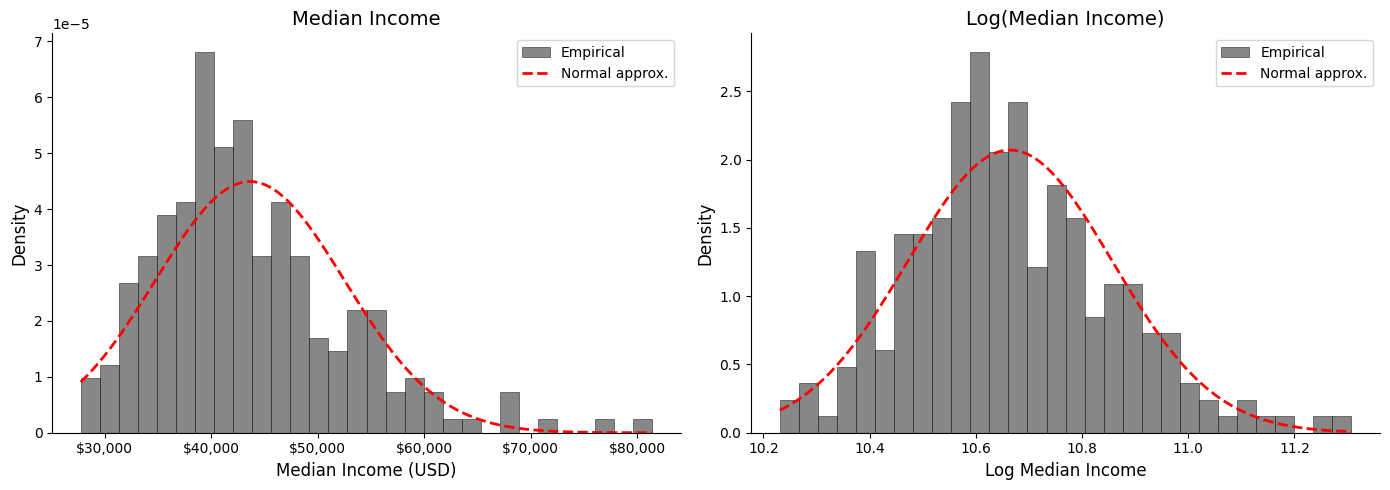

In [ ]:
# Histogram with Density Function Overlay:

# 1) Prepare the data:
vals_raw = train_df['med_income'].dropna()
vals_log = np.log(vals_raw)

# 2) Compute moments for each
mu_raw, sigma_raw = vals_raw.mean(), vals_raw.std()
mu_log, sigma_log = vals_log.mean(), vals_log.std()

# 3) Set up the figure with two panels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

for ax, vals, mu, sigma, title, xlabel in [
    (ax1, vals_raw, mu_raw, sigma_raw, "Median Income", "Median Income (USD)"),
    (ax2, vals_log, mu_log, sigma_log, "Log(Median Income)", "Log Median Income")
]:
    # histogram
    ax.hist(
        vals, bins=30, density=True,
        color='dimgray', edgecolor='black', linewidth=0.4, alpha=0.8,
        label='Empirical'
    )
    # fitted normal
    x = np.linspace(vals.min(), vals.max(), 200)
    pdf = (1/(sigma * np.sqrt(2*np.pi))) * np.exp(-(x-mu)**2/(2*sigma**2))
    ax.plot(x, pdf, 'r--', lw=2, label='Normal approx.')
    # clean up
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    if title == "Median Income":
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
    ax.legend()

plt.tight_layout()
plt.show()


As anticipated, the distribution is right-skewed (positively skewed), meaning most counties cluster in the lower‐to‐mid range, with fewer counties at very high median-income values (see left graph)

The skewness can cause a few headaches for the Ordinary Least Squares (Regression Model) such as producing skewed residuals and pulling the regression line to outliers, distorting the fit for the rest of the data.

As shown by the density function on the right, the log transformation improved the distibution. The data became normally distributed, which gave equal pull to all the data points, not just to the outliers

Next step: visualize Median Income (before & after transformation vs. each predictor) to measure the impact of the transformation

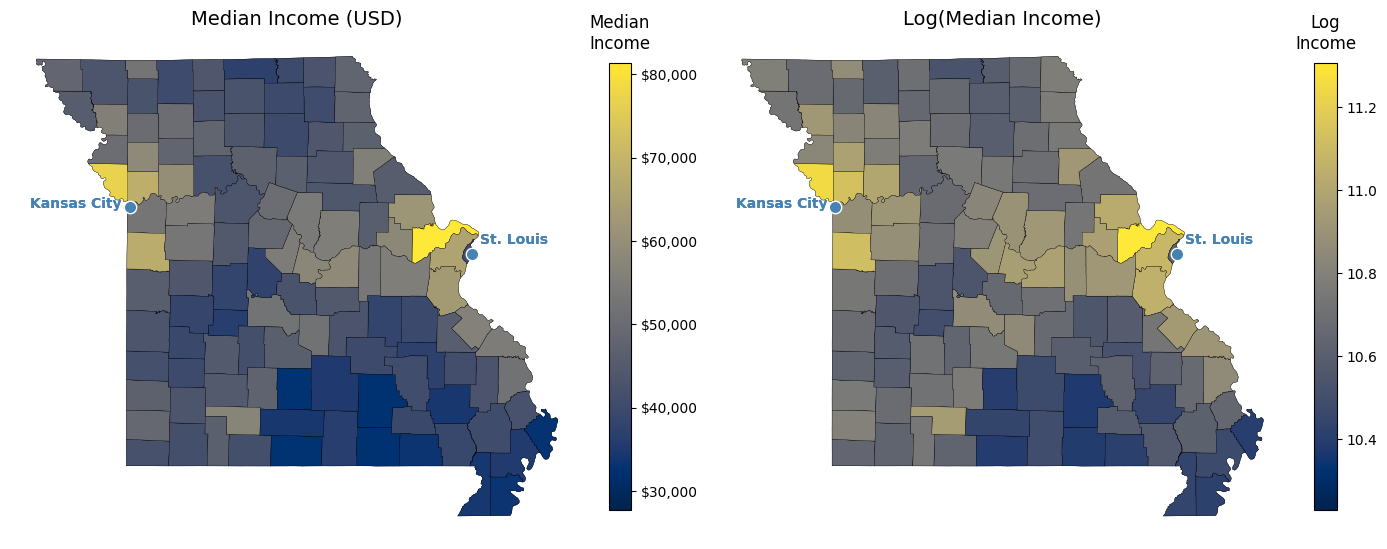

In [ ]:
# Median Income vs. Log Median Income (Choroepleth Map):

# Compute log median income
train_df = train_df.copy()
train_df['log_med_income'] = np.log(train_df['med_income'])

# Compute color bounds for each map
vmin_raw, vmax_raw = train_df['med_income'].min(), train_df['med_income'].max()
vmin_log, vmax_log = train_df['log_med_income'].min(), train_df['log_med_income'].max()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ---- Map of raw median income ----
norm_raw = mpl.colors.Normalize(vmin=vmin_raw, vmax=vmax_raw)
sm_raw = mpl.cm.ScalarMappable(cmap='cividis', norm=norm_raw)
sm_raw._A = []  # for colorbar
train_df.plot(
    column='med_income', cmap='cividis', norm=norm_raw,
    edgecolor='black', linewidth=0.2, ax=axes[0]
)
axes[0].set_title("Median Income (USD)", fontsize=14)
axes[0].axis('off')
cbar_raw = fig.colorbar(sm_raw, ax=axes[0], fraction=0.036, pad=0.04)
cbar_raw.ax.set_title("Median\nIncome", pad=10)
cbar_raw.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

# ---- Map of log median income ----
norm_log = mpl.colors.Normalize(vmin=vmin_log, vmax=vmax_log)
sm_log = mpl.cm.ScalarMappable(cmap='cividis', norm=norm_log)
sm_log._A = []
train_df.plot(
    column='log_med_income', cmap='cividis', norm=norm_log,
    edgecolor='black', linewidth=0.2, ax=axes[1]
)
axes[1].set_title("Log(Median Income)", fontsize=14)
axes[1].axis('off')
cbar_log = fig.colorbar(sm_log, ax=axes[1], fraction=0.036, pad=0.04)
cbar_log.ax.set_title("Log\nIncome", pad=10)

# City pins:
cities = {
    "Kansas City": (-94.5786, 39.0997),
    "St. Louis":   (-90.1994, 38.6270),
}
for ax in axes:
    for name, (lon, lat) in cities.items():
        ax.scatter(lon, lat, color='steelblue', edgecolor='white', s=80, zorder=5)
    # Labels
    axes[0].text(cities["St. Louis"][0]+0.1, cities["St. Louis"][1]+0.1, "St. Louis",
                 color='steelblue', fontsize=10, weight='bold')
    axes[0].text(cities["Kansas City"][0]-0.1, cities["Kansas City"][1]+0.1, "Kansas City",
                 ha='right', va='top', color='steelblue', fontsize=10, weight='bold')
    axes[1].text(cities["St. Louis"][0]+0.1, cities["St. Louis"][1]+0.1, "St. Louis",
                 color='steelblue', fontsize=10, weight='bold')
    axes[1].text(cities["Kansas City"][0]-0.1, cities["Kansas City"][1]+0.1, "Kansas City",
                 ha='right', va='top', color='steelblue', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

Indeed the median income distribution improved at a county level. The data looks more spread out now. One last check is to visualize the median income (before and after) vs. independant variable to decide if we should proceed with a log transformation

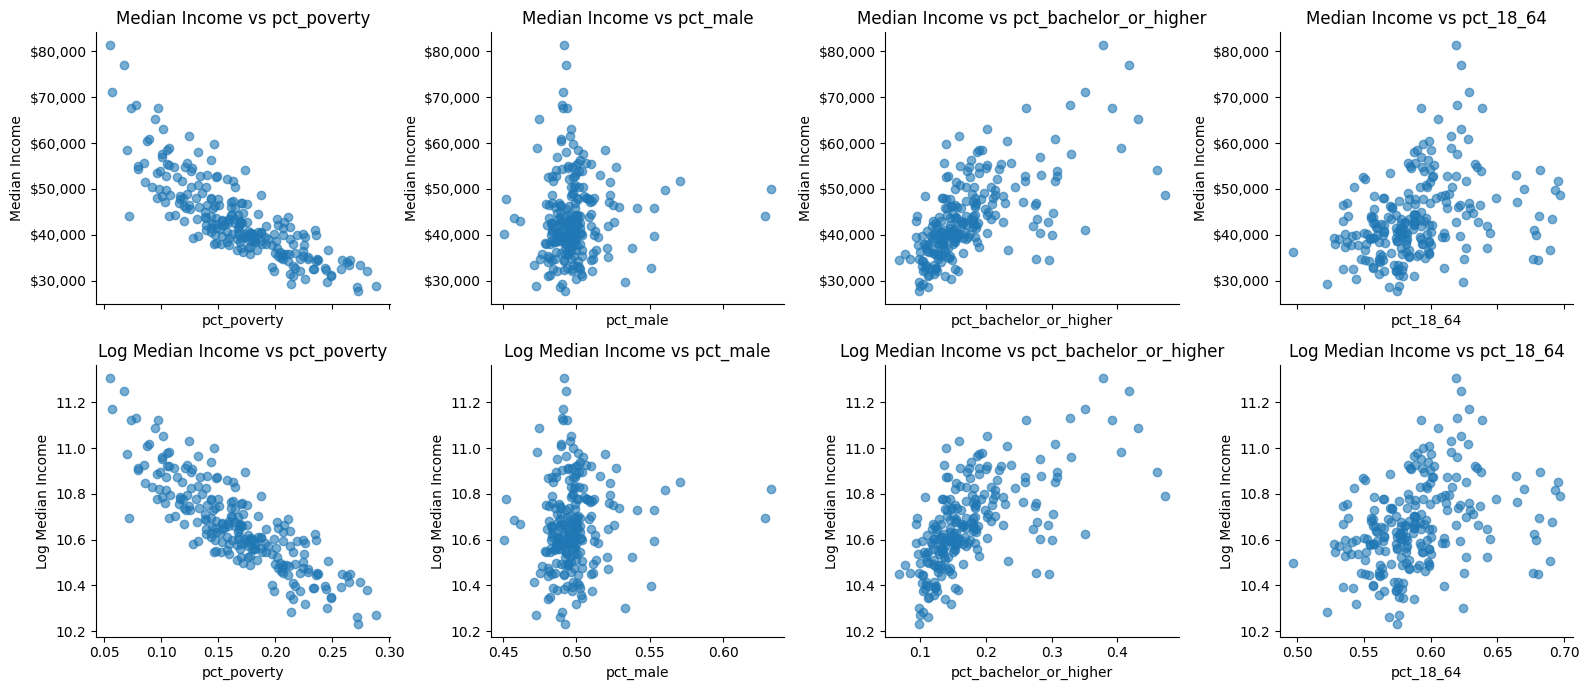

In [ ]:
# Median Income vs. Independent Variables Scatter Plots:

import numpy as np
import matplotlib.pyplot as plt

# make sure your DataFrame is ready
df = train_df.copy()

# ── Predictors to plot ──
predictors = ['pct_poverty', 'pct_male', 'pct_bachelor_or_higher', 'pct_18_64']

# ── Setup subplots: 2 rows (levels, log), one column per predictor ──
fig, axes = plt.subplots(
    2, len(predictors),
    figsize=(4 * len(predictors), 7),
    sharex='col'
)

for j, var in enumerate(predictors):
    # Top: raw median income
    ax = axes[0, j]
    ax.scatter(df[var], df['med_income'], alpha=0.6)
    ax.set_title(f"Median Income vs {var}", fontsize=12)
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel("Median Income", fontsize=10)
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Bottom: log median income
    ax = axes[1, j]
    ax.scatter(df[var], df['log_med_income'], alpha=0.6)
    ax.set_title(f"Log Median Income vs {var}", fontsize=12)
    ax.set_xlabel(var, fontsize=10)
    ax.set_ylabel("Log Median Income", fontsize=10)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

Compared the median income plots, the log median improved the following aspect:

* **Linearity**: In dollars the relationship “bends” at high values; on a log scale it straightens into a clear line.

* **Even spread**: Dollar‐plots fan out (heteroskedasticity), but log‐plots show a uniform cloud.

* **Signal clarity**: Outliers no longer dominate, so links with education and age stand out.

Based on our Exploratiy Data Analysis, the log median income will be used as the dependent variable due to the following insights:

* **Choropleth Median Income Map**:

  * Raw dollars: few counties dominate, most appear uniform.

  * Log scale: highlights variation across all counties.

* **Histogram with Density Overlay**:

  * Dollars: right-skewed, poor normal fit.

  * Log dollars: near-normal, variance stabilized.

* **Predictor Scatter-Plots**:

  * Dollars vs. predictors: curved, funnel shapes, some signs of heteroskedasticy/non-linearity

  * Log vs. predictors: improved linearity, constant spread.


##**🔧Model Specification**

We compare two approaches to predict county median income (log-transformed): a standard multiple linear regression and a spatial-lag regression model that accounts for neighbors’ incomes:


**Model 1: OLS (Multiple Linear Regression)**

$$
\log\bigl(\mathrm{med\_income}_{i}\bigr)
= \beta_{0}
+ \beta_{1}\,\mathrm{pct\_poverty}_{i}
+ \beta_{2}\,\mathrm{pct\_male}_{i}
+ \beta_{3}\,\mathrm{pct\_18\_64}_{i}
+ \beta_{4}\,\mathrm{pct\_bachelor\_or\_higher}_{i}
+ \varepsilon_{i}
$$


**Model 2: Spatial Lag Regression**

$$
\log\bigl(\mathrm{med\_income}_{i}\bigr)
= \rho \sum_{j} w_{ij}\,\log\bigl(\mathrm{med\_income}_{j}\bigr)
+ \beta_{0}
+ \beta_{1}\,\mathrm{pct\_poverty}_{i}
+ \beta_{2}\,\mathrm{pct\_male}_{i}
+ \beta_{3}\,\mathrm{pct\_18\_64}_{i}
+ \beta_{4}\,\mathrm{pct\_bachelor\_or\_higher}_{i}
+ \varepsilon_{i}
$$


Notation

𝑖
i indexes counties.

𝑤
𝑖
𝑗
w
ij
​
  are row-standardized contiguity weights.

𝜌
ρ measures spatial dependence (“spillover”) from neighboring counties.

𝜀
𝑖
ε
i
​
  is the model error term.

##**🔢Model Estimation**

In [ ]:
# Model 1: Multiple Linear Regression (OLS):

import statsmodels.formula.api as smf

est1 = smf.ols(formula = "log_med_income ~  pct_poverty + pct_male + pct_18_64 + pct_bachelor_or_higher", data = train_df)

model1 = est1.fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_med_income   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     263.9
Date:                Mon, 23 Jun 2025   Prob (F-statistic):           1.01e-83
Time:                        21:50:25   Log-Likelihood:                 252.94
No. Observations:                 230   AIC:                            -495.9
Df Residuals:                     225   BIC:                            -478.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 11

In [ ]:
# Queen contiguity weights:
w = Queen.from_dataframe(train_df)
w.transform = 'r'

y = train_df["log_med_income"].values.reshape((-1, 1))
X = train_df[["pct_poverty", "pct_male", "pct_18_64", "pct_bachelor_or_higher"]].values

model2 = ML_Lag(y, X, w=w, name_y="log_med_income", name_x=["pct_poverty", "pct_male", "pct_18_64", "pct_bachelor_or_higher"])

print(model2.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :log_med_income                Number of Observations:         230
Mean dependent var  :     10.6644                Number of Variables   :           6
S.D. dependent var  :      0.1926                Degrees of Freedom    :         224
Pseudo R-squared    :      0.8429
Spatial Pseudo R-squared:  0.8316
Log likelihood      :    264.8593
Sigma-square ML     :      0.0058                Akaike info criterion :    -517.719
S.E of regression   :      0.0762                Schwarz criterion     :    -497.090

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

/tmp/ipython-input-21-1031012231.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(train_df)


##**🧪 Diagnostic Checking**

OLS Diagnostics:

* Correlation Matrix
Examine pairwise correlations among predictors to spot collinearity.

* Variance Inflation Factor (VIF)
Quantify how much each predictor’s variance is inflated by multicollinearity (VIF > 5–10 flags concern).

* Residual vs. Fitted Plot
Check for non‐linearity, heteroskedasticity, or patterns indicating model misspecification.

* Residual Histogram
Assess whether residuals are approximately normally distributed (identifies skew or heavy tails).

* Normal Q–Q Plot
Compare residual quantiles against a theoretical normal to detect departures from normality.

* Shapiro–Wilk Test
Statistical test of normality on residuals (p < 0.05 suggests non‐normal errors).







In [ ]:
# Compute your correlation matrix
predictors = ['pct_poverty','pct_male','pct_bachelor_or_higher','pct_18_64']
corr = train_df[predictors].corr()

fig = px.imshow(
    corr,
    text_auto='.2f',    # show values rounded to 2 decimals
    aspect="auto",
    color_continuous_scale=px.colors.sequential.Cividis,
    zmin=-1, zmax=1,
    title="Predictor Correlation Matrix"
)

fig.update_layout(
    xaxis_title="",
    yaxis_title="",
    width=600,
    height=600
)

# Overlay a circle on any off‐diagonal cell where |corr| > 0.5
n = len(predictors)
for i, row in enumerate(predictors):
    for j, col in enumerate(predictors):
        if i != j and abs(corr.loc[row, col]) > 0.5:
            fig.add_shape(
                type="circle",
                xref="x", yref="y",
                x0=j - 0.4, x1=j + 0.4,
                y0=i - 0.4, y1=i + 0.4,
                line_color="black",
                line_width=2,
                fillcolor="rgba(0,0,0,0)"   # transparent fill
            )

fig.show()


Predictors are weakly correlated—aside from a moderate 0.56 link between the 18–64 age share and bachelor’s‐degree share. We'll compute VIFs to detect any multicollinearity, ensuring each variable contributes independent information and our coefficient estimates remain stable.

In [ ]:
# 3) Variance Inflation Factors:

X = train_df[predictors].copy()

X_vif = X.copy()
X_vif['const'] = 1.0

vif = []
for i, var in enumerate(X_vif.columns):
    vif.append(variance_inflation_factor(X_vif.values, i))

vif_df = pd.DataFrame({
    'variable': X_vif.columns,
    'VIF': np.round(vif, 2)
})
print("=== Variance Inflation Factors ===")
print(vif_df)

=== Variance Inflation Factors ===
                 variable     VIF
0             pct_poverty    1.36
1                pct_male    1.51
2  pct_bachelor_or_higher    2.21
3               pct_18_64    1.99
4                   const  835.34


The VIF values are below the usual thresholds (5 or 10), so there’s no sign of worrisome multicollinearity among your actual explanatory variables.

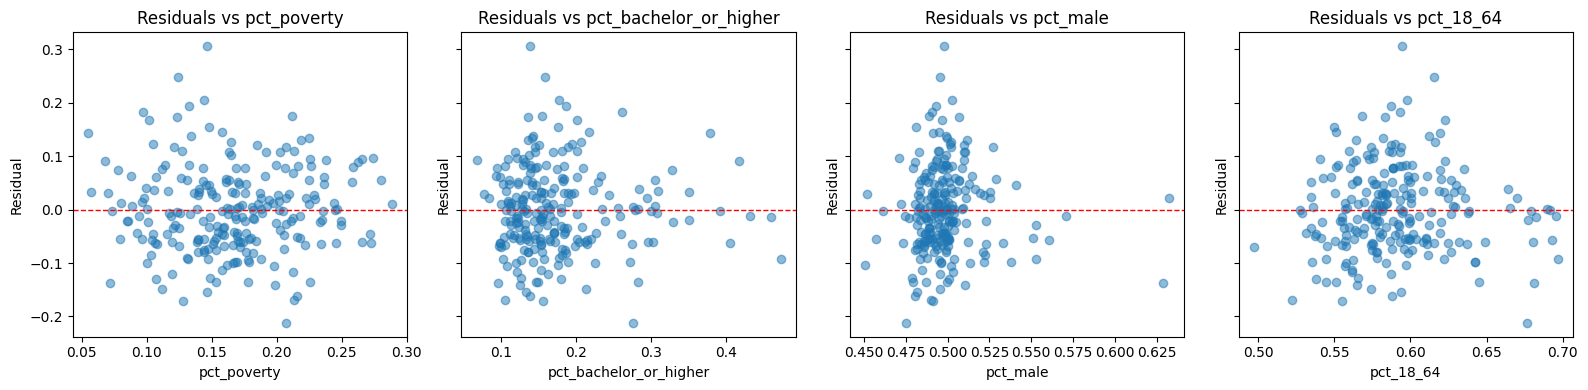

In [ ]:
# residuals plot check (OLS Model aka model1):

import matplotlib.pyplot as plt
import statsmodels.api as sm

df_used = model1.model.data.frame.copy()

resid1 = model1.resid

predictors = ['pct_poverty', 'pct_bachelor_or_higher', 'pct_male', 'pct_18_64']

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
axes = axes.flatten()

for ax, var in zip(axes, predictors):
    x = df_used[var]
    ax.scatter(x, resid1, alpha=0.5)
    ax.axhline(0, color='red', linestyle='--', linewidth=1)
    ax.set_xlabel(var)
    ax.set_ylabel('Residual')
    ax.set_title(f'Residuals vs {var}')


plt.tight_layout()
plt.show()

The residual‐vs‐predictor plots show no obvious patterns or funnels. The points are scattered fairly randomly around zero across the full range of each covariate.

This suggests our log‐linear specification adequately captures the main structure, and there’s no strong heteroskedasticity or nonlinearity left in these predictors.

(array([ 4., 12., 41., 57., 56., 35., 16.,  6.,  2.,  1.]),
 array([-0.21171911, -0.15994214, -0.10816517, -0.05638821, -0.00461124,
         0.04716573,  0.0989427 ,  0.15071967,  0.20249663,  0.2542736 ,
         0.30605057]),
 <BarContainer object of 10 artists>)

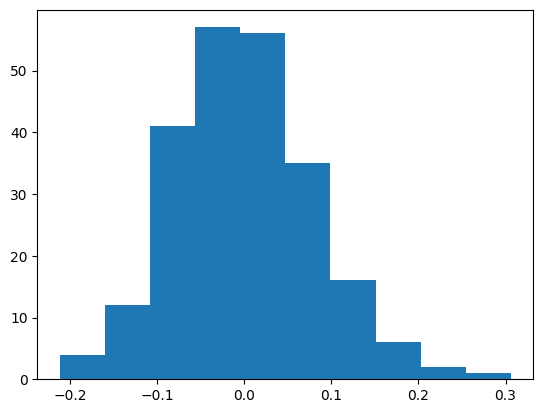

In [ ]:
# Residual distribution (OLS Model aka model1):

plt.hist(resid1)

The residuals form a roughly symmetric, bell-shaped curve centered at zero, with most values between –0.1 and +0.1 and no extreme outliers. This approximate normality and consistent spread support our OLS assumptions and validate the reliability of standard errors and t-tests.









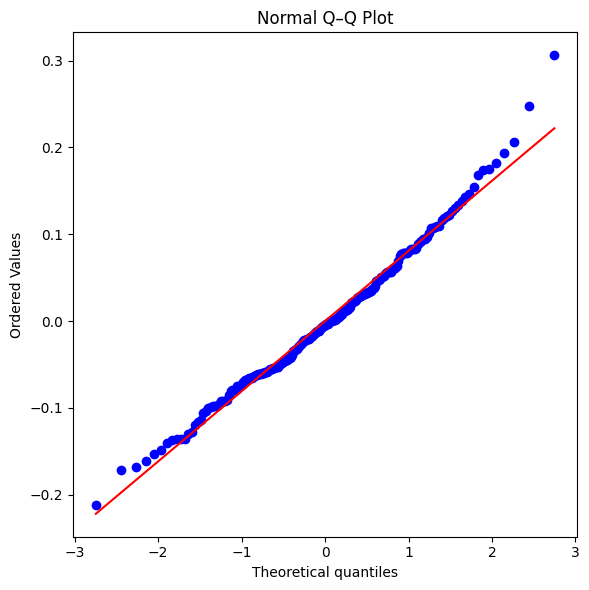

In [ ]:
# QQ Plot:

plt.figure(figsize=(6,6))
stats.probplot(resid1, dist="norm", plot=plt)
plt.title("Normal Q–Q Plot")
plt.tight_layout()
plt.show()

The Q-Q plot shows that the bulk of our residuals fall almost exactly along the 45° reference line, indicating they’re very close to normally distributed.

In [ ]:
# Shapiro-Wilk Test:

from scipy.stats import shapiro

W_stat, p_value = shapiro(resid1)

print(f"Shapiro–Wilk W = {W_stat:.4f}, p-value = {p_value:.4f}")

Shapiro–Wilk W = 0.9876, p-value = 0.0442


Even though the Shapiro–Wilk test now returns W = 0.9876 with p = 0.0442 (just below 0.05), the Q–Q plot and histogram suggest only very mild departures from normality in the residuals—largely in the extreme tails. In practice, slight non‐normality at the edges, especially with a sample size this large, won’t meaningfully bias your coefficient estimates or invalidate standard errors.

Overall, the OLS model seems to be healthy, now let's move on to the Spatial-Lag Regression model



Spatial‐Lag Regression Diagnostics

* Residual Scatter Plot
Plots residuals versus fitted values (or spatial coordinates) to spot non‐random patterns or model misspecification.

* Moran’s I Test
Quantifies leftover spatial autocorrelation in the residuals—ideally near zero—confirming the lag term has captured spatial dependence.

* Breusch–Pagan Test
Checks for heteroskedasticity (variance changing over space); a non‐significant result supports the assumption of constant error variance.





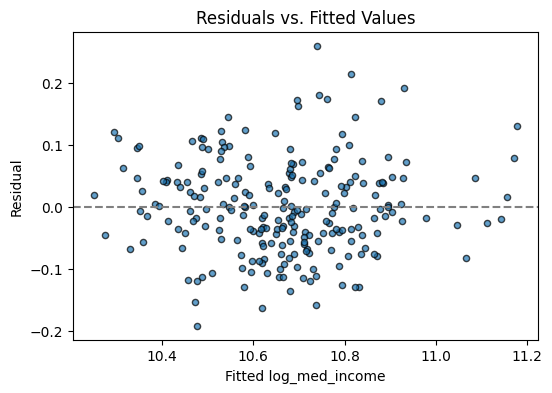

In [ ]:
# Residual Scatter Plots:

fitted = model2.predy.flatten()
resid  = model2.u.flatten()
plt.figure(figsize=(6,4))
plt.scatter(fitted, resid, s=20, edgecolor='k', alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Fitted log_med_income")
plt.ylabel("Residual")
plt.title("Residuals vs. Fitted Values")
plt.show()

That residual‐vs‐fitted scatter for the spatial‐lag model looks quite clean. No obvious funnel shape, centered around zero, and no curvature or trend.

In [ ]:
# Moran's Test:
resid = model2.u.flatten()
moran = Moran(resid, w)
print(f"Moran’s I on residuals: {moran.I:.4f}, p-value = {moran.p_norm:.4f}")


/tmp/ipython-input-29-3806455707.py:2: FutureWarning:

`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning



y.shape: (230, 1)
X.shape: (230, 4)
w.n: 230
Moran’s I on residuals: 0.0522, p-value = 0.0433


That small but positive Moran’s I (0.0522) with p = 0.0433 tells us there’s still a bit of spatial clustering in the residuals even after including the spatial‐lag term.

We need additional reassurance that our model errors were well behaved. Therefore, we are going to run a Breusch-Pagan test:

In [ ]:
# Breusch-Pagan Test:

exog     = sm.add_constant(train_df[["pct_poverty",
                                     "pct_male",
                                     "pct_18_64",
                                     "pct_bachelor_or_higher"]])
bp_stat, bp_pval, _, _ = het_breuschpagan(resid, exog)
print("BP p-value:", bp_pval)


BP p-value: 0.8337467196753688


That very high Breusch–Pagan p-value (0.8337) means we fail to reject the null of constant variance. The Breusch–Pagan test results confirms homoskedasticity and stenghtens our confidence in the model's validity

So far both models seem to be healthy. To help us pick our champion model, we'll compute and compare some metrics in the Model Assessment:

##**📊 Model Assessment**

We assess each model’s performance on three fronts:

* Goodness of Fit

 * R² & Adjusted R²: Fraction of variance explained, with the adjusted version penalizing extra parameters.

 * AIC & BIC: Information‐criteria that trade off model fit and complexity (lower is better).

* Predictive Accuracy

 * RMSE (dollars): Root‐mean‐square error on the test set, back‐transformed to dollar units.

* Diagnostic Checks

 * Breusch–Pagan Test for heteroskedasticity in the residuals.

 * Moran’s I on residuals to quantify any leftover spatial autocorrelation.

Finally, we’ll map and compare the residuals from both models side by side—visually to ensure the spatial‐lag specification has effectively captured geographic patterns of error.

In [ ]:
# transform median income to log in our test sample:

test_df['log_med_income'] = np.log(test_df['med_income'])

In [ ]:
try:
    from esda.moran import Moran
    moran_available = True
except ImportError:
    moran_available = False

# Predictor sets
full_preds = ['pct_poverty','pct_male','pct_18_64','pct_bachelor_or_higher']
pars_preds = ['pct_poverty','pct_male','pct_18_64','pct_bachelor_or_higher']

# Build weights
w_train = Queen.from_dataframe(train_df); w_train.transform = 'r'
w_test  = Queen.from_dataframe(test_df);  w_test.transform  = 'r'
Wt      = w_test.sparse
I_test  = sparse.identity(Wt.shape[0])

# Extract arrays (log-scale)
y_train_log = train_df['log_med_income'].values
y_test_log  = test_df ['log_med_income'].values

X_train_full = train_df[full_preds].values
X_test_full  = test_df [full_preds].values
X_train_pars = train_df[pars_preds].values
X_test_pars  = test_df [pars_preds].values
df_test      = test_df.drop(columns='geometry')

# Define back-transform with smearing for a fitted log-model
def back_transform_smear(mod, y_pred_log):
    # residuals on log-scale
    resid_log = mod.u.flatten() if hasattr(mod, 'u') else mod.resid
    # smearing factor
    smear = np.mean(np.exp(resid_log))
    # back-transform predictions
    return np.exp(y_pred_log) * smear

# Predict spatial‐lag on log-scale
def predict_lag_log(mod, X, W, I):
    coefs = mod.betas.flatten()
    intercept, *betas, rho = coefs
    linpart_log = X.dot(np.array(betas)) + intercept
    return spsolve(I - rho * W, linpart_log)

# Assemble models
models = {
    'full'  : model1,
    'spat'  : model2
}

# Compute metrics with RMSE in dollars
rows = []
for name, mod in models.items():
    # select design matrices
    if name in ('full','spat'):
        Xtr, Xte = X_train_full, X_test_full
    else:
        Xtr, Xte = X_train_pars, X_test_pars

    # Fit measures
    r2     = getattr(mod,'rsquared',None) or getattr(mod,'pr2',None)
    adj_r2 = getattr(mod,'rsquared_adj',None) or getattr(mod,'pr2',None)
    aic    = getattr(mod,'aic',np.nan)
    bic    = getattr(mod,'bic',np.nan)

    # In-sample residuals & RMSE (log-scale)
    # predict log
    if name in ('spat','f_spat'):
        yhat_train_log = predict_lag_log(mod, Xtr, w_train.sparse, sparse.identity(Xtr.shape[0]))
    else:
        yhat_train_log = mod.fittedvalues
    # back-transform with smear
    y_train_d = np.exp(y_train_log)
    yhat_train_d = back_transform_smear(mod, yhat_train_log)
    rmse_train_d = np.sqrt(mean_squared_error(y_train_d, yhat_train_d))

    # Breusch–Pagan on log residuals
    resid_log = mod.u.flatten() if hasattr(mod,'u') else mod.resid
    bp_pval   = het_breuschpagan(resid_log, sm.add_constant(Xtr))[1]

    # Moran’s I
    if moran_available:
        m        = Moran(resid_log, w_train)
        mi, mp   = m.I, m.p_norm
    else:
        mi = mp = np.nan

    # Out-of-sample RMSE (dollars)
    if name in ('spat','f_spat'):
        yhat_test_log = predict_lag_log(mod, Xte, Wt, I_test)
    else:
        yhat_test_log = mod.predict(df_test)
    y_test_d        = np.exp(y_test_log)
    yhat_test_d     = back_transform_smear(mod, yhat_test_log)
    rmse_test_d     = np.sqrt(mean_squared_error(y_test_d, yhat_test_d))

    rows.append({
        'Model'       : name,
        'R²'          : r2,
        'Adj. R²'     : adj_r2,
        'AIC'         : aic,
        'BIC'         : bic,
        'Train RMSE ($)' : rmse_train_d,
        'Test RMSE ($)'  : rmse_test_d,
        'BP p-value'  : bp_pval,
        'Moran’s I'   : mi,
        'Moran p-val' : mp
    })

# Final table
df_metrics = pd.DataFrame(rows).set_index('Model').round({
    'R²':3, 'Adj. R²':3, 'AIC':2, 'BIC':2,
    'Train RMSE ($)':0, 'Test RMSE ($)':0,
    'BP p-value':4, 'Moran’s I':4, 'Moran p-val':4
})
print(df_metrics)


/tmp/ipython-input-32-3967593404.py:20: FutureWarning:

`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning



          R²  Adj. R²     AIC     BIC  Train RMSE ($)  Test RMSE ($)  \
Model                                                                  
full   0.824    0.821 -495.88 -478.69          3700.0        13390.0   
spat   0.843    0.843 -517.72     NaN          3602.0        12287.0   

       BP p-value  Moran’s I  Moran p-val  
Model                                      
full       0.4911     0.1122       0.0000  
spat       0.8337     0.0522       0.0433  


/tmp/ipython-input-32-3967593404.py:21: FutureWarning:

`use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning



Compared to plain OLS, the spatial‐lag model delivers across the board:

=> Improved fit & parsimony:

𝑅
2
R
2
  ↑ from 0.824 → 0.843

AIC ↓ by ~22 points

Better out-of-sample accuracy:

Test RMSE ↓ from $13,390 to $12,287 (≈ 8 % gain)

=> Reduced spatial autocorrelation:

Moran’s I on residuals falls from 0.112 → 0.052, indicating far less unexplained geographic clustering

=> No added heteroskedasticity:

Breusch–Pagan p = 0.8337

By explicitly modeling the spillover parameter
ρ, the spatial-lag model captures neighborhood effects in county incomes,improving both predictive performance and the validity of our residuals. Now, let's compare the models visually:

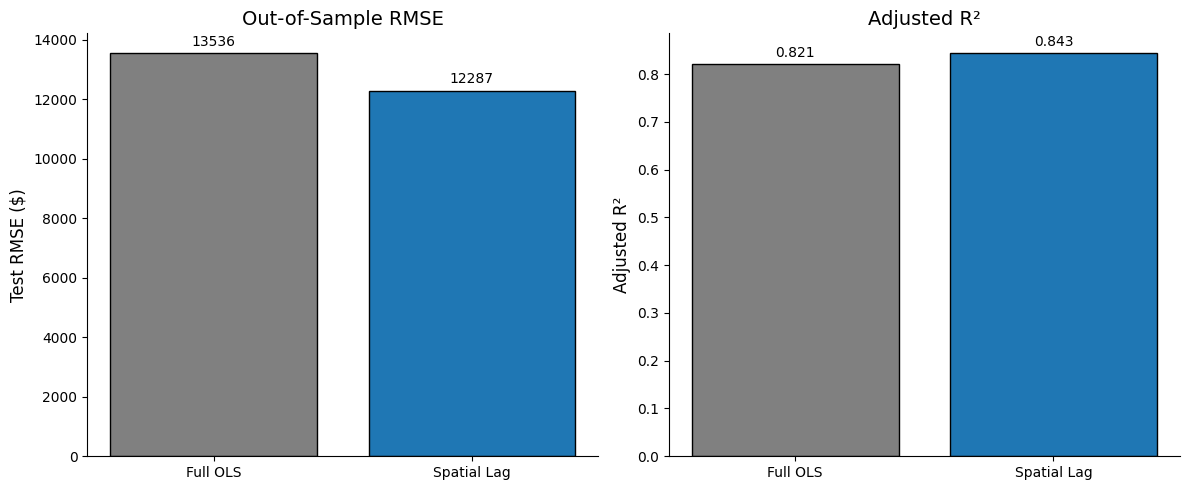

In [ ]:
# Prepare data
df_rmse = pd.DataFrame({
    'Model': ['Full OLS', 'Spatial Lag'],
    'Test RMSE ($)': [13536.0, 12287.0],
}).set_index('Model')

df_r2 = pd.DataFrame({
    'Model': ['Full OLS', 'Spatial Lag'],
    'Adj. R²': [0.821, 0.843],
}).set_index('Model')

# Determine best models
best_rmse = df_rmse['Test RMSE ($)'].idxmin()
best_r2   = df_r2['Adj. R²'].idxmax()

# Colors: highlight best, grey out the other
colors_rmse = ['C0' if m == best_rmse else 'grey' for m in df_rmse.index]
colors_r2   = ['C0' if m == best_r2   else 'grey' for m in df_r2.index]

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# 1) Test RMSE bar chart
bars0 = axes[0].bar(df_rmse.index, df_rmse['Test RMSE ($)'],
                    color=colors_rmse, edgecolor='black')
axes[0].bar_label(bars0, fmt='%.0f', padding=3)
axes[0].set_ylabel('Test RMSE ($)', fontsize=12)
axes[0].set_title('Out-of-Sample RMSE', fontsize=14)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)

# 2) Adjusted R² bar chart
bars1 = axes[1].bar(df_r2.index, df_r2['Adj. R²'],
                    color=colors_r2, edgecolor='black')
axes[1].bar_label(bars1, fmt='%.3f', padding=3)
axes[1].set_ylabel('Adjusted R\u00b2', fontsize=12)
axes[1].set_title('Adjusted R\u00b2', fontsize=14)
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


Model Comparison Summary

=> Out-of-Sample RMSE
The Spatial Lag model delivers a lower test RMSE 12,287 compared to the OLS 13,536, indicating better predictive accuracy when accounting for spatial spillovers.

=> Adjusted R²
The Spatial Lag model also achieves a higher Adjusted R² (0.843 vs 0.821), showing it explains more variance in the held-out data after penalizing for model complexity.



Since the goal of this analysis is to predict county level median income, let's run one more comparison before we announce the champion model, which is mapping the absolute residuals from both the OLS and Spatial Lag models side-by-side—highlighting in green the counties where the Spatial Lag residuals are smaller (i.e. “improved”) and in gray those where they are not.

In [ ]:
# extract residuals:
resid_ols  = model1.resid  if hasattr(model2, 'resid')  else model2.u.flatten()
resid_spat = model2.u.flatten()

train_df = train_df.copy()
train_df['resid_ols']  = model1.resid
train_df['resid_spat'] = model2.u.flatten()

# Compute improvement flag
train_df['improved'] = np.abs(train_df['resid_spat']) < np.abs(train_df['resid_ols'])

# --- 7) Interactive map ---
# Requires geopandas >=0.10 for .explore()
train_df['resid_diff'] = train_df['resid_spat'] - train_df['resid_ols']

m = train_df.explore(
    column='improved',
    categorical=True,
    cmap=['lightgrey','seagreen'],
    legend=True,
    legend_kwds={'title': 'Improved?'},
    tooltip=[
        'NAME',
        'geoid',
        ('resid_ols'),
        ('resid_spat'),
        ('resid_diff'),
        ('improved')
    ],
    style_kwds={'fillOpacity':0.7, 'weight':0.5}
)
m  # in Jupyter this will display the interactive map


This interactive map makes it crystal clear where the Spatial‐Lag model outperforms plain OLS at the county level:

  => Green counties are those where the absolute prediction error (“residual”) decreases once we include the spatial lag.

  => Gray counties show little to no improvement (or worse) under the Spatial model.

By scanning this, we can see that most counties—especially around Kansas City, St. Louis, and other clusters—benefit from modeling spatial spillovers. This local view not only validates the overall RMSE/R² gains but also pinpoints exactly where the Spatial‐Lag model delivers its biggest predictive boost.

In [ ]:
# Number / Percentage of Counties whose residuals improved:

# Total unique counties
total_counties = train_df['geoid'].nunique()

# How many of those counties ever “improved”
improved_counties = train_df.loc[train_df['improved'], 'geoid'].nunique()

# Compute the percentage
pct_improved = improved_counties / total_counties * 100

print(f"{improved_counties} out of {total_counties} unique counties improved "
      f"({pct_improved:.1f}%) after adding the spatial lag.")


83 out of 115 unique counties improved (72.2%) after adding the spatial lag.


##**🚀 Model Deployment**

Based on the Model Assessment section, the Spatial Lag Regression Model wins 🥇

To deploy this model, FastAPI is used:

In [ ]:
# app.py
import joblib, numpy as np
from fastapi import FastAPI
from pydantic import BaseModel

class ParcelFeatures(BaseModel):
  pct_poverty: float
  pct_male: float
  pct_18_64: float
  pct_bachelor_or_higher: float

artefact = joblib.load("median_income_model.pkl")
model     = artefact['model']
smear     = artefact['smear']
preds     = artefact['full_preds']

app = FastAPI()
@app.post("/predict/")
def predict(f: ParcelFeatures):
    x = np.array([[ getattr(f,p) for p in preds ]])
    yhat_log = model.predict(x)               # or predict_lag_log if spatial
    yhat     = np.exp(yhat_log) * smear
    return {"predicted_med_income": float(yhat)}

if __name__=="__main__":
  import uvicorn
  uvicorn.run(app, host="0.0.0.0", port=8000)


FileNotFoundError: [Errno 2] No such file or directory: 'median_income_model.pkl'